# Rent Value Prediction Model

## Main topics: Data cleaning, data analysis and Regression Models

## 1) Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import folium
import statsmodels.api as sm 
nltk.download('stopwords')
from nltk import FreqDist, bigrams, trigrams
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import RegexpTokenizer, stopwords
from folium.plugins import HeatMap
from sklearn.preprocessing import LabelEncoder
from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2) Reading the CSV and studying the data superficially

In [2]:
df = pd.read_csv('housing_train.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       265190 non-null  int64  
 1   url                      265190 non-null  object 
 2   region                   265190 non-null  object 
 3   region_url               265190 non-null  object 
 4   price                    265190 non-null  int64  
 5   type                     265190 non-null  object 
 6   sqfeet                   265190 non-null  int64  
 7   beds                     265190 non-null  int64  
 8   baths                    265190 non-null  float64
 9   cats_allowed             265190 non-null  int64  
 10  dogs_allowed             265190 non-null  int64  
 11  smoking_allowed          265190 non-null  int64  
 12  wheelchair_access        265190 non-null  int64  
 13  electric_vehicle_charge  265190 non-null  int64  
 14  come

id                                                url      region  \
0  7039061606  https://bham.craigslist.org/apa/d/birmingham-h...  birmingham   
1  7041970863  https://bham.craigslist.org/apa/d/birmingham-w...  birmingham   
2  7041966914  https://bham.craigslist.org/apa/d/birmingham-g...  birmingham   
3  7041966936  https://bham.craigslist.org/apa/d/birmingham-f...  birmingham   
4  7041966888  https://bham.craigslist.org/apa/d/birmingham-2...  birmingham   

                    region_url  price       type  sqfeet  beds  baths  \
0  https://bham.craigslist.org   1195  apartment    1908     3    2.0   
1  https://bham.craigslist.org   1120  apartment    1319     3    2.0   
2  https://bham.craigslist.org    825  apartment    1133     1    1.5   
3  https://bham.craigslist.org    800  apartment     927     1    1.0   
4  https://bham.craigslist.org    785  apartment    1047     2    1.0   

   cats_allowed  ...  wheelchair_access  electric_vehicle_charge  \
0             1  ...                  0                        0   
1             1  ...                  0                        0   
2             1  ...                  0                        0   
3             1  ...                  0                        0   
4             1  ...                  0                        0   

   comes_furnished  laundry_options     parking_options  \
0                0  laundry on site      street parking   
1                0  laundry on site  off-street parking   
2                0  laundry on site      street parking   
3                0  laundry on site      street parking   
4                0  laundry on site      street parking   

                                           image_url  \
0  https://images.craigslist.org/00L0L_80pNkyDeG0...   
1  https://images.craigslist.org/00707_uRrY9CsNMC...   
2  https://images.craigslist.org/00h0h_b7Bdj1NLBi...   
3  https://images.craigslist.org/00808_6ghZ8tSRQs...   
4  https://images.craigslist.org/00y0y_21c0FOvUXm...   

                                         description      lat     long  state  
0  Apartments In Birmingham AL Welcome to 100 Inv...  33.4226 -86.7065     al  
1  Find Your Way to Haven Apartment Homes Come ho...  33.3755 -86.8045     al  
2  Apartments In Birmingham AL Welcome to 100 Inv...  33.4226 -86.7065     al  
3  Apartments In Birmingham AL Welcome to 100 Inv...  33.4226 -86.7065     al  
4  Apartments In Birmingham AL Welcome to 100 Inv...  33.4226 -86.7065     al  

[5 rows x 22 columns]

As we can see, there are some columns that have null values, let's see better which ones.

In [4]:
df.isnull().sum()

id                             0
url                            0
region                         0
region_url                     0
price                          0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options            54311
parking_options            95135
image_url                      0
description                    2
lat                         1419
long                        1419
state                          1
dtype: int64

## 3) Data analysis and Data cleaning

### 3.1) Working with the null values

Since we need to know the location of the places to create a good model, we are going to eliminate all the rows that lacks of long or latitude.

In [3]:
df.dropna(axis='index', subset=['lat', 'long'], inplace = True)

We still have a lot of null values of laundry options and parking options. Both of them are strings, therefore we can't replace with the mean or the median. So our options are:
1) Drops the columns.
2) Replace with mode (if it is an easy thing to do)
3) Talk to a professional expert to understand what might that mean. For example, maybe a null value means that "no laundry on site".

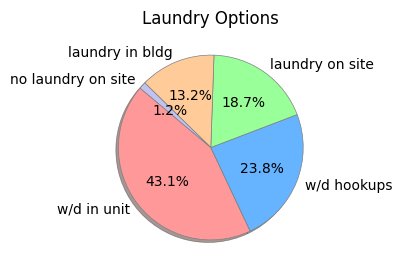

In [4]:
laundry_options = df['laundry_options'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']
plt.figure(figsize=(4, 3)) 
plt.pie(laundry_options, labels = laundry_options.index, autopct='%1.1f%%', startangle=140, 
        colors=colors, shadow=True, wedgeprops={'linestyle': 'solid', 'linewidth': 0.5, 'edgecolor': 'gray'})
plt.title('Laundry Options')

plt.show()

In [11]:
print(f'null values           ' + str(df['laundry_options'].isnull().sum()))
print(laundry_options)

null values           54127
w/d in unit           113642
w/d hookups            62691
laundry on site        49286
laundry in bldg        34926
no laundry on site      3226
Name: laundry_options, dtype: int64


There are 54k missing values, which it is a huge amount to just replace with the mode. Therefore, now we have to decide if just drop the columns or replace by a random value, by always tying to maintain the percentages of distribution in the sample. Since dropping the rows would be too easy, for this time, let's use the last option that I described.

We are going to use Rangom Sample Imputation, it means, we are replacing the missing rows with random values from the dataset.But we know that there are 43% of chances of replacing a single row with w/d in unit, 24% with w/d hookups, and the rest.

In [5]:
amount_miss_values_laundry = df['laundry_options'].isnull().sum() #define the amount of missing values in the column
random_laundry_options = df['laundry_options'].dropna().sample( amount_miss_values_laundry ) # generating the random options
random_laundry_options.index = df[df['laundry_options'].isnull()].index #joining the indexes
df.loc[df['laundry_options'].isnull(), 'laundry_options'] = random_laundry_options #from the dataframe df, we are selecting the location in all the
# rows that are nulls in the 'laundry_options', with the 'laundry_options' column. Then we are giving them the values of the random sample that we
# created before.

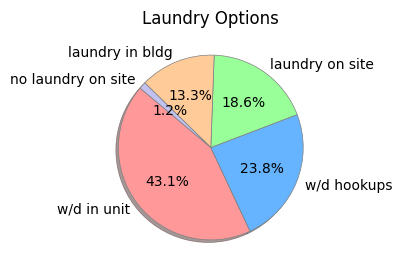

null values           0
w/d in unit           113652
w/d hookups            62833
laundry on site        49137
laundry in bldg        34956
no laundry on site      3193
Name: laundry_options, dtype: int64


In [6]:
laundry_options_no_null = df['laundry_options'].value_counts()

plt.figure(figsize=(4, 3)) 
plt.pie(laundry_options_no_null, labels = laundry_options_no_null.index, autopct='%1.1f%%', startangle=140, 
        colors=colors, shadow=True, wedgeprops={'linestyle': 'solid', 'linewidth': 0.5, 'edgecolor': 'gray'})
plt.title('Laundry Options')

plt.show()

print(f'null values           ' + str(df['laundry_options'].isnull().sum()))
print(laundry_options_no_null)

Great, now we have the same distribution, but with no null values. 
Let's continue with the null values for parking options.

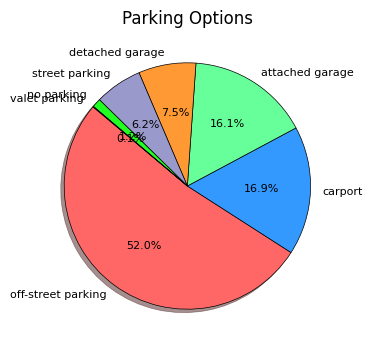

null values           94444
off-street parking    88099
carport               28614
attached garage       27211
detached garage       12763
street parking        10551
no parking             1967
valet parking           122
Name: parking_options, dtype: int64


In [7]:
parking_options = df['parking_options'].value_counts()
colors = ['#ff6666', '#3399ff', '#66ff99', '#ff9933', '#9999cc', '#22ff22']
plt.figure(figsize=(6, 4)) 
plt.pie(parking_options, labels = parking_options.index, autopct='%1.1f%%', startangle=140, 
        colors=colors, shadow=True, wedgeprops={'linestyle': 'solid', 'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 8})
plt.title('Parking Options')

plt.show()
print(f'null values           ' + str(df['parking_options'].isnull().sum()))
print(parking_options)

In [8]:
amount_miss_values_parking = df['parking_options'].isnull().sum() #define the amount of missing values in the column
random_parking_options = df['parking_options'].dropna().sample( amount_miss_values_parking) # generating the random options
random_parking_options.index = df[df['parking_options'].isnull()].index #joining the indexes
df.loc[df['parking_options'].isnull(), 'parking_options'] = random_parking_options #from the dataframe df, we are selecting the location in all the
# rows that are nulls in the 'parking_options', with the 'parking_options' column. Then we are giving them the values of the random sample that we
# created before.

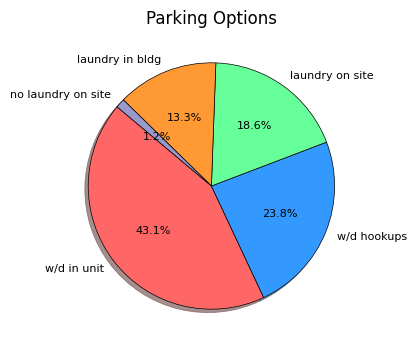

null values           0
w/d in unit           113652
w/d hookups            62833
laundry on site        49137
laundry in bldg        34956
no laundry on site      3193
Name: laundry_options, dtype: int64


In [9]:
parking_options_no_null = df['laundry_options'].value_counts()

plt.figure(figsize=(6, 4)) 
plt.pie(parking_options_no_null, labels = parking_options_no_null.index, autopct='%1.1f%%', startangle=140, 
        colors=colors, shadow=True, wedgeprops={'linestyle': 'solid', 'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 8})
plt.title('Parking Options')

plt.show()

print(f'null values           ' + str(df['laundry_options'].isnull().sum()))
print(parking_options_no_null)

We have almost the same distribution so we can continue with this new dataframe.

In [13]:
df.isnull().sum()

id                         0
url                        0
region                     0
region_url                 0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
image_url                  0
description                2
lat                        0
long                       0
state                      0
dtype: int64

We have only 2 more null values, in the description column.

In [10]:
df['description'].fillna(value = 'nothing', inplace = True)
df['description'] = df['description'].str.lower()

Finally, we are to continue with the analysis.

### 3.2) Text Analysis on "Description"

Cuantitative data is important when analyzing patterns and studying different events. This is because, as it is said, "numbers don't lie". However, with the developing of more sofisticated analyzing tools and algorithms, now we can analyze the cualitative data, in this case, by focusing on the description.

In [15]:
complete_description = ''
stop_words = set(STOPWORDS)

When analyzing text we need to define tokens, this one could be characters, sentences or in this case, words. We are defining each token as a different word.

In [16]:
for content in df['description'].iloc[0:10000]:

    content = str(content) # we make sure all the description is in string format
    
    tokens = content.split()  #we split the content into words (tokens)
    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    complete_description = complete_description + " ".join(tokens)+" "

Since we have all the description, now we need to generate the wordcloud

(-0.5, 799.5, 799.5, -0.5)

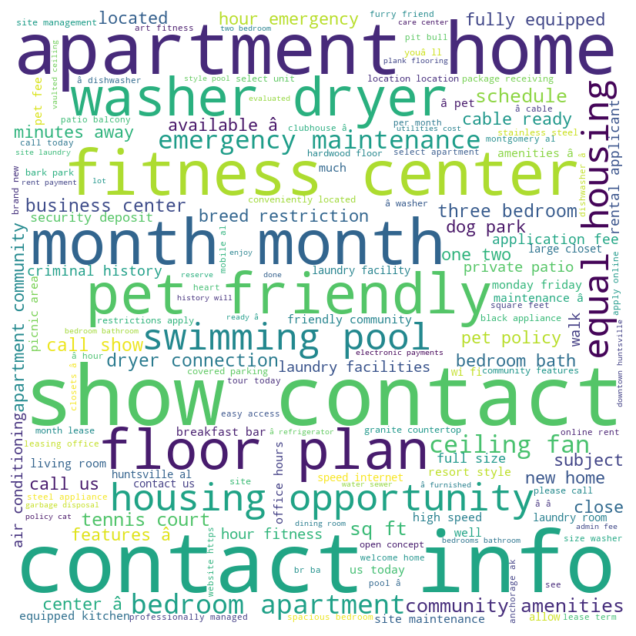

In [17]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(complete_description) 
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off")

### 3.3) Studying key words in description

Now we are going to study all the important words in the description. First we are seting the regular expersion reconizer to identify words with any letter.

In [18]:
tokenizer = RegexpTokenizer("[a-zA-Z]+") 
print(tokenizer.tokenize(df['description'][0]))

['apartments', 'in', 'birmingham', 'al', 'welcome', 'to', 'inverness', 'apartment', 'homes', 'a', 'luxury', 'apartment', 'community', 'tucked', 'away', 'into', 'one', 'of', 'the', 'most', 'coveted', 'locations', 'in', 'the', 'city', 'for', 'birmingham', 'apartments', 'find', 'stylish', 'one', 'two', 'and', 'three', 'bedroom', 'apartment', 'floor', 'plans', 'tailored', 'to', 'your', 'wants', 'and', 'needs', 'complete', 'with', 'the', 'amenities', 'that', 'are', 'important', 'to', 'you', 'our', 'layouts', 'come', 'with', 'just', 'enough', 'variety', 'to', 'enable', 'you', 'to', 'make', 'it', 'your', 'own', 'haven', 'unlike', 'any', 'other', 'get', 'inspired', 'by', 'our', 'photos', 'and', 'the', 'serenity', 'of', 'the', 'nature', 'surrounding', 'you', 'to', 'let', 'your', 'aesthetic', 'come', 'together', 'with', 'our', 'stylish', 'modern', 'designs', 'for', 'a', 'home', 'you', 'won', 't', 'be', 'able', 'to', 'wait', 'to', 'show', 'off', 'to', 'your', 'guests', 'even', 'beyond', 'style', 

In [19]:
description_tokens = df['description'].apply(tokenizer.tokenize)
description_tokens.head()

0    [apartments, in, birmingham, al, welcome, to, ...
1    [find, your, way, to, haven, apartment, homes,...
2    [apartments, in, birmingham, al, welcome, to, ...
3    [apartments, in, birmingham, al, welcome, to, ...
4    [apartments, in, birmingham, al, welcome, to, ...
Name: description, dtype: object

We have to define the stopwords (words that are wellknown for not adding more information value to the sentences)

In [22]:
stop = stopwords.words("english")

let's see and example of how do they work

In [23]:
print(description_tokens[0])
print(len(description_tokens[0]))

['apartments', 'in', 'birmingham', 'al', 'welcome', 'to', 'inverness', 'apartment', 'homes', 'a', 'luxury', 'apartment', 'community', 'tucked', 'away', 'into', 'one', 'of', 'the', 'most', 'coveted', 'locations', 'in', 'the', 'city', 'for', 'birmingham', 'apartments', 'find', 'stylish', 'one', 'two', 'and', 'three', 'bedroom', 'apartment', 'floor', 'plans', 'tailored', 'to', 'your', 'wants', 'and', 'needs', 'complete', 'with', 'the', 'amenities', 'that', 'are', 'important', 'to', 'you', 'our', 'layouts', 'come', 'with', 'just', 'enough', 'variety', 'to', 'enable', 'you', 'to', 'make', 'it', 'your', 'own', 'haven', 'unlike', 'any', 'other', 'get', 'inspired', 'by', 'our', 'photos', 'and', 'the', 'serenity', 'of', 'the', 'nature', 'surrounding', 'you', 'to', 'let', 'your', 'aesthetic', 'come', 'together', 'with', 'our', 'stylish', 'modern', 'designs', 'for', 'a', 'home', 'you', 'won', 't', 'be', 'able', 'to', 'wait', 'to', 'show', 'off', 'to', 'your', 'guests', 'even', 'beyond', 'style', 

In [24]:
print([token for token in description_tokens[0] if token not in stop])
print(len([token for token in description_tokens[0] if token not in stop]))

['apartments', 'birmingham', 'al', 'welcome', 'inverness', 'apartment', 'homes', 'luxury', 'apartment', 'community', 'tucked', 'away', 'one', 'coveted', 'locations', 'city', 'birmingham', 'apartments', 'find', 'stylish', 'one', 'two', 'three', 'bedroom', 'apartment', 'floor', 'plans', 'tailored', 'wants', 'needs', 'complete', 'amenities', 'important', 'layouts', 'come', 'enough', 'variety', 'enable', 'make', 'unlike', 'get', 'inspired', 'photos', 'serenity', 'nature', 'surrounding', 'let', 'aesthetic', 'come', 'together', 'stylish', 'modern', 'designs', 'home', 'able', 'wait', 'show', 'guests', 'even', 'beyond', 'style', 'pet', 'friendly', 'apartment', 'community', 'also', 'functionality', 'homes', 'come', 'washer', 'dryer', 'hookups', 'wood', 'burning', 'fireplaces', 'hardwood', 'floors', 'private', 'patio', 'balcony', 'residents', 'make', 'use', 'oversized', 'walk', 'closets', 'air', 'conditioning', 'garages', 'business', 'center', 'site', 'management', 'maintenance', 'laundry', 'fac

In [25]:
def remove_stopwords(list_with_tokens):
    final_list = []
    for token in list_with_tokens:
        if token not in stop:
            final_list.append(token)
    return final_list

In [26]:
description_tokens = description_tokens.apply(remove_stopwords) #this line should take around 2:30 minutes.

Now we need to include this information in original dataframe

In [28]:
indexes = []
for i in range (0, len(description_tokens)):
    indexes.append(i)

review_info = pd.Series(data = description_tokens.values, index = indexes)
print(review_info.head())

0    [apartments, birmingham, al, welcome, invernes...
1    [find, way, apartment, homes, come, home, apar...
2    [apartments, birmingham, al, welcome, invernes...
3    [apartments, birmingham, al, welcome, invernes...
4    [apartments, birmingham, al, welcome, invernes...
dtype: object


In [45]:
list_all_the_words = [word for sublist in description_tokens for word in sublist]
fdist = FreqDist(list_all_the_words)
print(fdist.most_common(10))

[('community', 292873), ('contact', 291461), ('apartment', 278442), ('apartments', 255815), ('info', 245191), ('home', 242896), ('bedroom', 242381), ('show', 236710), ('call', 229891), ('pet', 216950)]


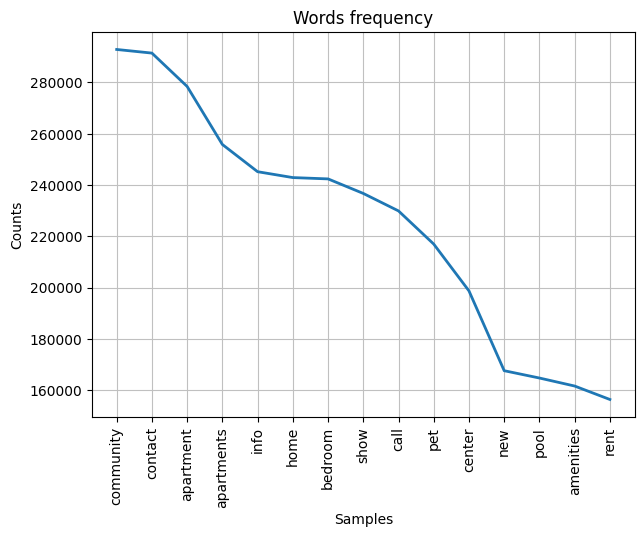

<AxesSubplot: title={'center': 'Words frequency'}, xlabel='Samples', ylabel='Counts'>

In [48]:
plt.figure(figsize = (7, 5))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Words frequency')
fdist.plot(15)

In [47]:
# Genera bigramas para cada lista en la serie
serie_bigrams = description_tokens.apply(lambda x: list(bigrams(x)))

# Combina todas las listas de bigramas en una única lista de bigramas
list_all_the_bigrams = [bigram for sublist in serie_bigrams for bigram in sublist]

# Crea un objeto FreqDist a partir de la lista de bigramas
fdist_bigram = FreqDist(list_all_the_bigrams)

# Imprime los bigramas más comunes y sus frecuencias
print(fdist_bigram.most_common(10))

[(('contact', 'info'), 233197), (('show', 'contact'), 227832), (('washer', 'dryer'), 119820), (('fitness', 'center'), 104045), (('call', 'show'), 80230), (('pet', 'friendly'), 77737), (('apartment', 'homes'), 72889), (('sq', 'ft'), 67319), (('swimming', 'pool'), 64751), (('housing', 'opportunity'), 59337)]


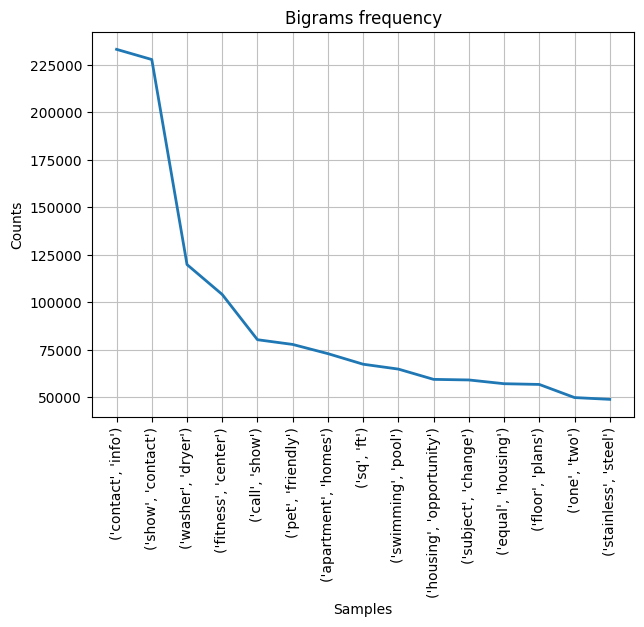

<AxesSubplot: title={'center': 'Bigrams frequency'}, xlabel='Samples', ylabel='Counts'>

In [49]:
plt.figure(figsize = (7, 5))
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Bigrams frequency')
fdist_bigram.plot(15)

As we can see, contact info and show contact are the 2 most frequent bigrams in the descriptions.

[(('show', 'contact', 'info'), 227821), (('call', 'show', 'contact'), 80202), (('equal', 'housing', 'opportunity'), 55628), (('stainless', 'steel', 'appliances'), 38174), (('availability', 'subject', 'change'), 30220), (('two', 'three', 'bedroom'), 29338), (('one', 'two', 'three'), 28277), (('hour', 'fitness', 'center'), 23515), (('hour', 'emergency', 'maintenance'), 22750), (('pet', 'friendly', 'community'), 20268)]


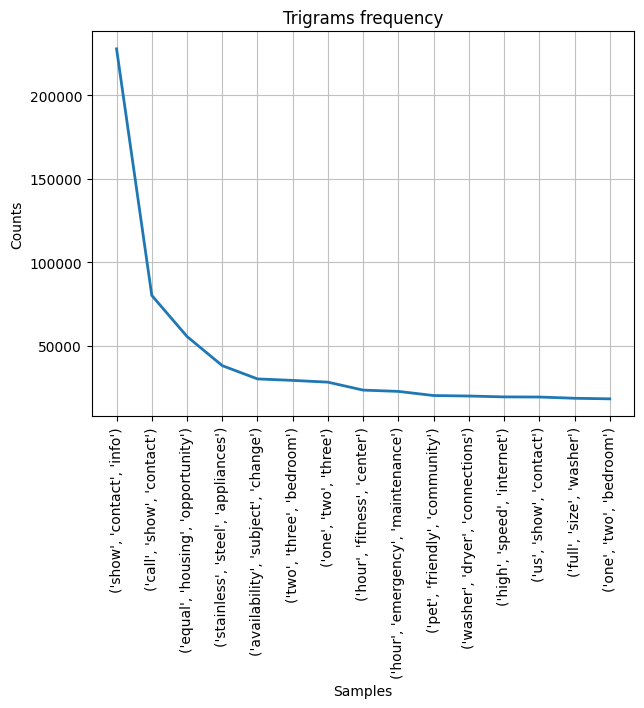

<AxesSubplot: title={'center': 'Trigrams frequency'}, xlabel='Samples', ylabel='Counts'>

In [50]:
# Genera bigramas para cada lista en la serie
serie_trigrams = description_tokens.apply(lambda x: list(trigrams(x)))

# Combina todas las listas de bigramas en una única lista de bigramas
list_all_the_trigrams = [trigram for sublist in serie_trigrams for trigram in sublist]

# Crea un objeto FreqDist a partir de la lista de bigramas
fdist_trigram = FreqDist(list_all_the_trigrams)

# Imprime los bigramas más comunes y sus frecuencias
print(fdist_trigram.most_common(10))

plt.figure(figsize = (7, 5))
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Trigrams frequency')
fdist_trigram.plot(15)

### 3.4) Maping the prices and demand

In [15]:
world_map = folium.Map(zoom_start = 2)
HeatMap(data = df[['lat', 'long', 'price']], radius = 15).add_to(world_map)
world_map

### 3.5) Analysing quantitative features

We are going to look forward into this fuature that can be measure but number (even if it is a binary answer like, if they accept or not dogs, 0 or 1)

In [59]:
quant_features = ['beds', 'baths']

binary_features = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 
                  'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']

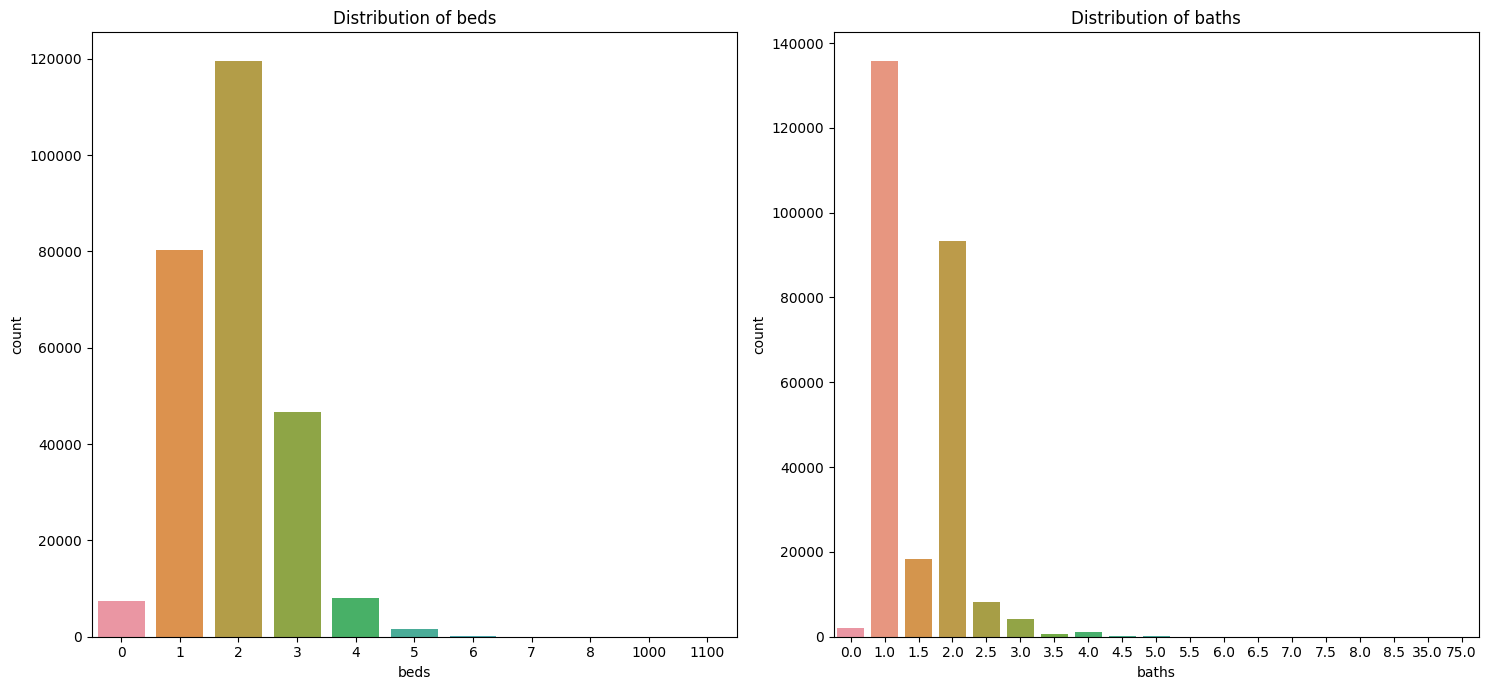

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

for i, feature in enumerate(quant_features):
    col = i   # Calcula la columna actual
    sns.countplot(data=df, x=feature, ax=axes[col])
    axes[col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

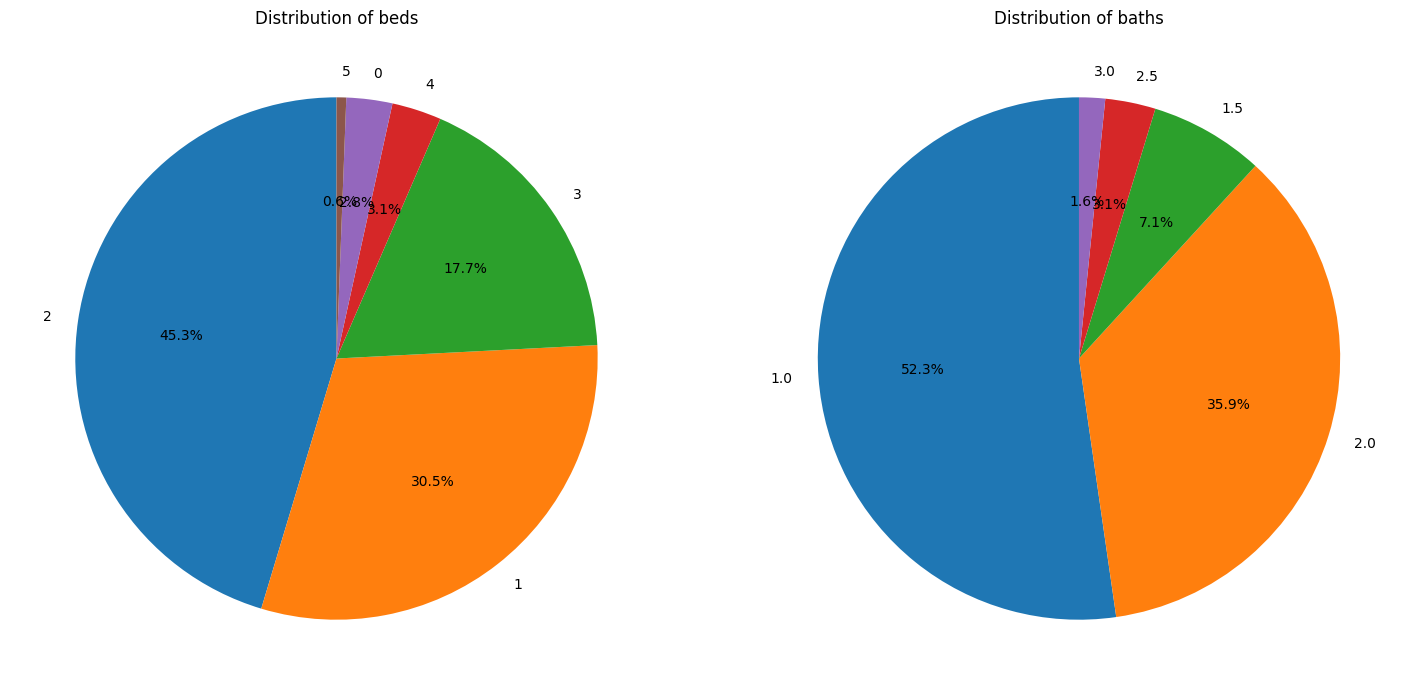

In [92]:
value_ranges = [(0, 5), (1.0, 3.0)]  # Rangos de valores para 'beds' y 'baths'
labels = ['0', '1', '2', '3', '4', '5']  # Etiquetas para 'beds'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

for i, feature in enumerate(quant_features):
    col = i   # Calcula la columna actual
    ax = axes[col]
    
    # Filtra los datos dentro del rango específico
    filtered_data = df[(df[feature] >= value_ranges[i][0]) & (df[feature] <= value_ranges[i][1])]
    
    # Cuenta los valores dentro del rango y crea un gráfico de torta
    counts = filtered_data[feature].value_counts()
    
    # Asegúrate de que haya suficientes etiquetas para los valores
    labels = counts.index.astype(str)
    
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    
    ax.set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

Beds: Most of the places offers 1, 2 or 3 beds (more that 75%)

Baths: Most of the places only counts with 1 or 2 bathrooms

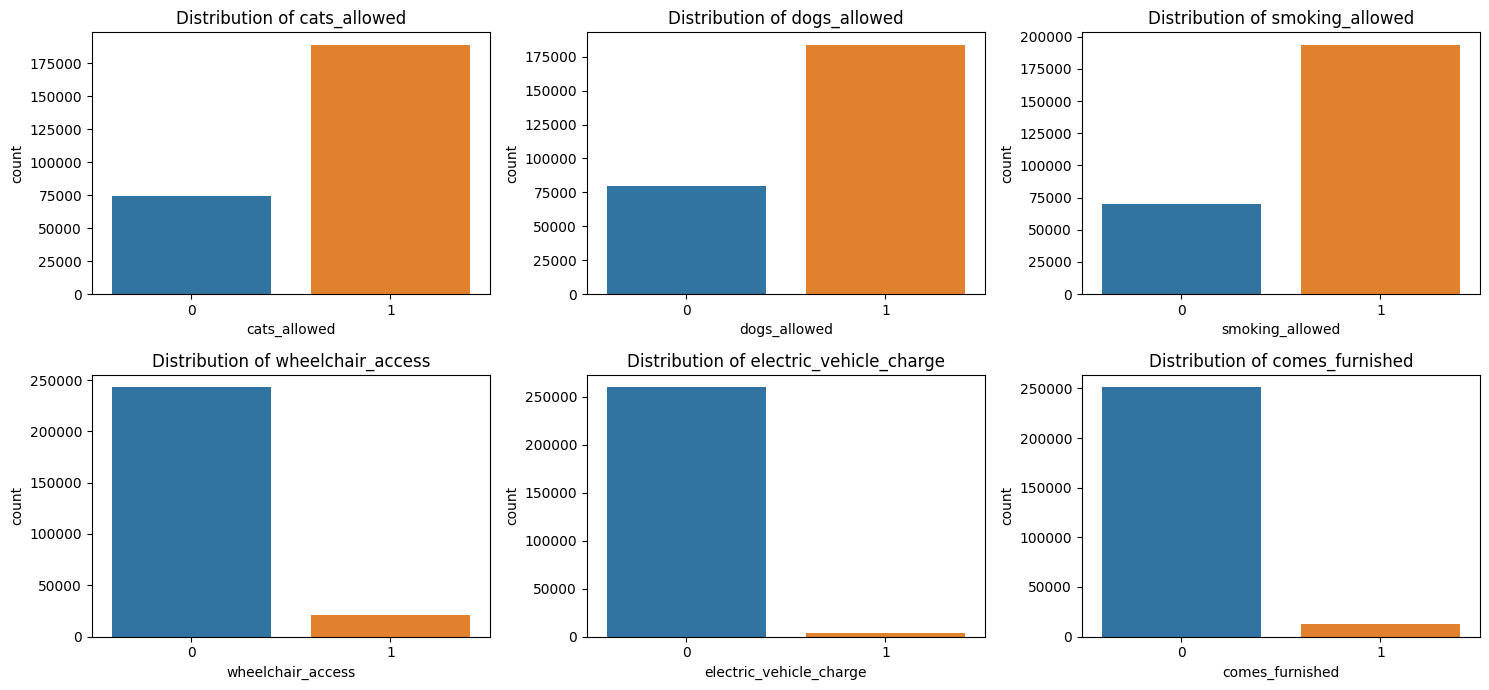

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

for i, feature in enumerate(binary_features):
    row = i // 3  # Calcula la fila actual
    col = i % 3   # Calcula la columna actual
    sns.countplot(data=df, x=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

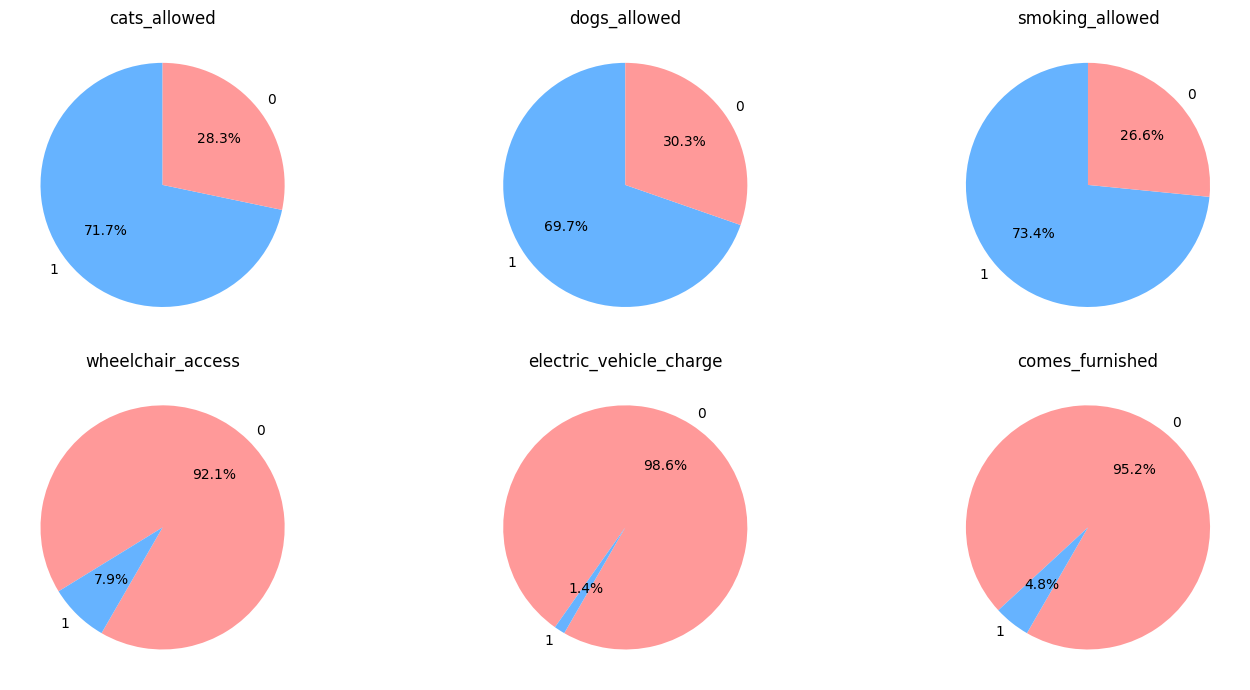

In [88]:
colors = ['#ff9999', '#66b3ff']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

for i, feature in enumerate(binary_features):
    row = i // 3 
    col = i % 3  
    
    counts = df[feature].value_counts()
    
    if 1 == counts.index[1]:
        colors = ['#ff9999', '#66b3ff']
        inclination = -120
    else:
        colors = ['#66b3ff', '#ff9999']
        inclination = 90

    axes[row, col].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle= inclination, colors=colors)
    axes[row, col].set_title(f'{feature}')
    
plt.tight_layout()
plt.show()

Almost 7 out of 10 places allow cat, dogs and smoking. However, other facilities are not very much offered.

### 4) Outliers

Usually data comes with outliers. Even when we can recognize them just looking at them, I think it is better to let the math identify them. However, let's show some graphics so you know they are there.

### 4.1) Price Outliers

<AxesSubplot: >

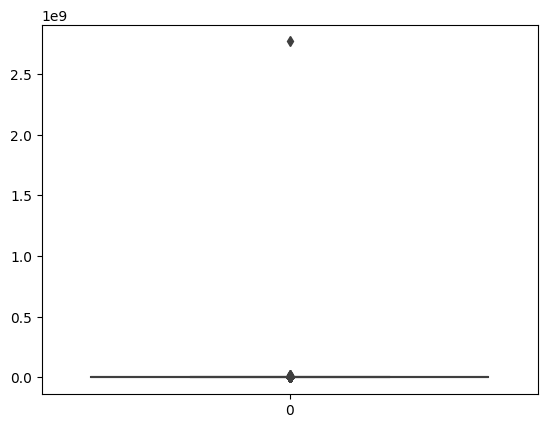

In [20]:
sns.boxplot(df['price'])

When we have outliers in our data, we can:

1) Remove the rows: It is good because you don't take any risks about "guessing" the correct value, but at the same time you lose important information (depending of the amount of outliers)
2) Replace them by the mean: Good to avoid losing information but it can work pretty bad for data that is charged to the edges.
3) Replace them by the median: Good to avoid losing information but it can work pretty bad for data that is charged to the edges.
4) Replace them by the mode: Good to avoid losing information, however it can give you wrong information if your data is well distribuited.
5) Transform them by Scaling, Log transfomation, Cube Root Normalization, Box-cox transformation. These techniques are usually good 

In [21]:
print(df['price'].max())
print(df['price'].median())
print(df['price'].mean())
print(df['price'].mode())
print(df['price'].describe())

2768307249
1060.0
12330.078647766433
0    750
Name: price, dtype: int64
count    2.637710e+05
mean     1.233008e+04
std      5.390794e+06
min      0.000000e+00
25%      8.180000e+02
50%      1.060000e+03
75%      1.450000e+03
max      2.768307e+09
Name: price, dtype: float64


We can see that the outliers in 'price' affect have a huge effect on the mean, but not in the median. Therefore, we are going to replace the outliers with the median. In order to identify them we are using the modified z-score.

Why do I want to use the modified one? When having a dataset which mean has been moved a lot by the outliers, usually the z-score loses its accuracy to identify them, because it relies on the 'mean'. However, the median is a great option to use when we have cases where the mean is that much different from the median (Like now, where mean > 10 * median ||  mean > 10 * value_of_percentile_75). 
Deeper explanations can be found in this link: https://www.statology.org/modified-z-score/

Finally, let's use both just to see the huge difference between them. 

Note: To change the dataframe we are going to create a copy.

In [11]:
data = df.copy()

In [12]:
std = data['price'].std()
mean =  data['price'].mean()
median = data['price'].median()

### Using standard z-score

data['z_score'] = (data['price'] - mean) / std

### Using modified z-score

data['difference'] = abs(median -  data['price'])
mad_value = data['difference'].median()
data['mod_z_score'] = 0.6745 * (data['price'] - median) / mad_value


### Difference
print(f'Outliers found with classic z-score: ' + str(len(data[abs(data['z_score']) > 3.5])))

print(f'Outliers found with modified z-score: ' + str(len(data[abs(data['mod_z_score']) > 3.5])))

Outliers found with classic z-score: 2
Outliers found with modified z-score: 10216


In [24]:
data['mod_z_score'].describe()

count    2.637710e+05
mean     2.621265e+01
std      1.253824e+04
min     -2.465414e+00
25%     -5.628586e-01
50%      0.000000e+00
75%      9.070862e-01
max      6.438698e+06
Name: mod_z_score, dtype: float64

Outliers found: 10216
2564.0
1060.0
1131.9672935993722
0    1060.0
Name: price, dtype: float64
count    263771.000000
mean       1131.967294
std         442.098167
min           0.000000
25%         818.000000
50%        1060.000000
75%        1375.000000
max        2564.000000
Name: price, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_15868\3721374334.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['price'])


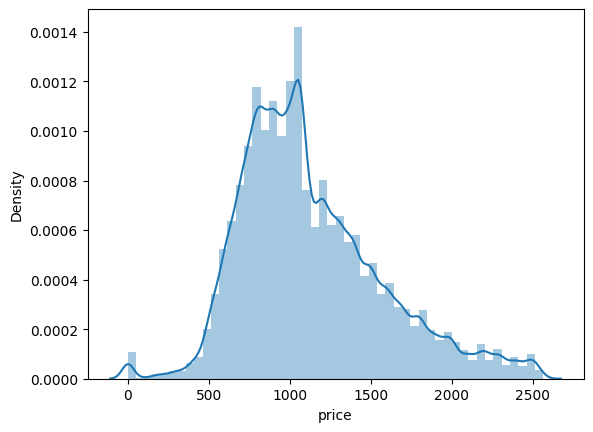

In [13]:
data['price'] = np.where(data['mod_z_score'] > 3.5, median, data['price'])

print(f'Outliers found: ' + str(len(data[data['mod_z_score'] > 3.5])))

print(data['price'].max())
print(data['price'].median())
print(data['price'].mean())
print(data['price'].mode())
print(data['price'].describe())

sns.distplot(data['price'])


data.drop('difference', axis=1, inplace=True)
data.drop('mod_z_score', axis=1, inplace=True)

As we can see, the data exhibits a positively skewed normal distribution.

Now let's do the same with the square feet of the property.

### 4.2) Squeare feet Outliers

195751    8388607
7862      8000000
42751     1019856
42752     1019856
63022      999999
176790     999999
252045     999999
252048     999999
99761      775814
121757      99204
122525      99202
48012       95242
42435       95209
41661       92037
16350       72916
131234      63134
255276      50000
257858      50000
258685      50000
258686      50000
Name: sqfeet, dtype: int64

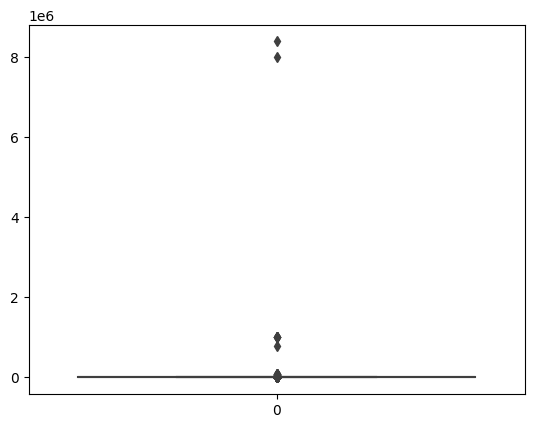

In [22]:
sns.boxplot(data['sqfeet'])
data['sqfeet'].nlargest(20)

Outliers found: 6546
1987.0
950.0
959.9533079830611
0    950.0
Name: sqfeet, dtype: float64
count    263771.000000
mean        959.953308
std         294.542357
min           0.000000
25%         752.000000
50%         950.000000
75%        1125.000000
max        1987.000000
Name: sqfeet, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_15868\2739236327.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['sqfeet'])


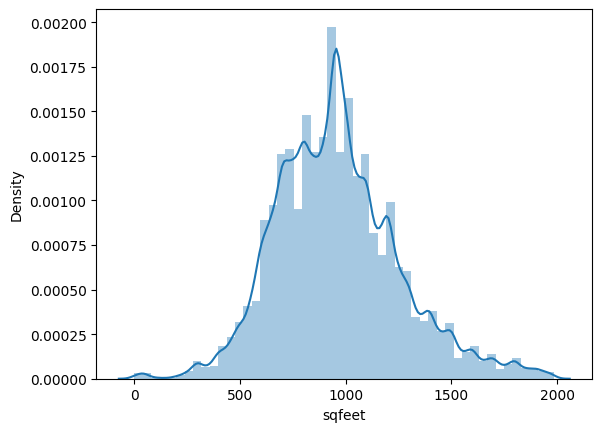

In [14]:
median = data['sqfeet'].median()

data['difference'] = abs(median -  data['sqfeet'])
mad_value = data['difference'].median()
data['mod_z_score'] = 0.6745 * (data['sqfeet'] - median) / mad_value

data['sqfeet'] = np.where(data['mod_z_score'] > 3.5, median, data['sqfeet'])

print(f'Outliers found: ' + str(len(data[data['mod_z_score'] > 3.5])))

print(data['sqfeet'].max())
print(data['sqfeet'].median())
print(data['sqfeet'].mean())
print(data['sqfeet'].mode())
print(data['sqfeet'].describe())

sns.distplot(data['sqfeet'])


data.drop('difference', axis=1, inplace=True)
data.drop('mod_z_score', axis=1, inplace=True)

### 4.3) Beds Outliers

125920    1100
126923    1100
73839     1000
52993        8
76257        8
Name: beds, dtype: int64

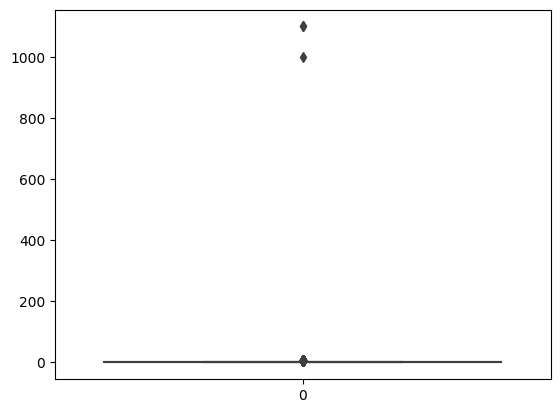

In [24]:
sns.boxplot(data['beds'])
data['beds'].nlargest(5) 

Using "data['beds'].nlargest(5)"  we know that we have 3 outliers. 

In [268]:
print(data['beds'].max())
print(data['beds'].median())
print(data['beds'].mean())
print(data['beds'].mode())
print(data['beds'].describe())

1100
2.0
1.9107331738515607
0    2
Name: beds, dtype: int64
count    263771.000000
mean          1.910733
std           3.701121
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1100.000000
Name: beds, dtype: float64


NOTE: Looking at the data, we only see 3 outliers manually, but more important than that, we can see that the median and the mean are not that different from each other. Therefore, using the standard z-score method is better for this data.

In [15]:
median = data['beds'].median()
std = data['beds'].std()
mean =  data['beds'].mean()

data['z_score'] = (data['beds'] - mean) / std

print(f'Outliers found: ' + str(len(data[data['z_score'] > 3])))

Outliers found: 3


8.0
2.0
1.8986241853729182
0    2.0
Name: beds, dtype: float64
count    263771.000000
mean          1.898624
std           0.882400
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           8.000000
Name: beds, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_15868\2039156955.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['beds'])


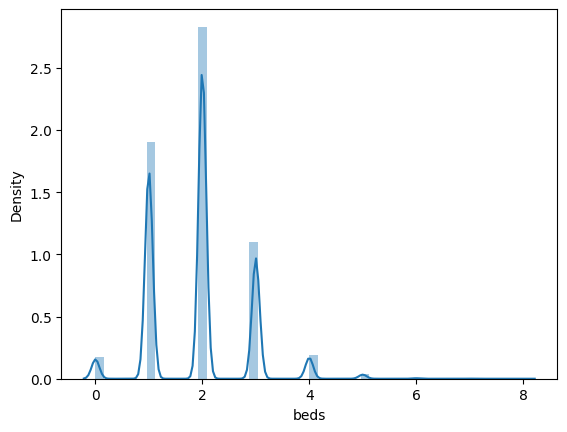

In [16]:
data['beds'] = np.where(data['z_score'] > 3, median, data['beds'])

print(data['beds'].max())
print(data['beds'].median())
print(data['beds'].mean())
print(data['beds'].mode())
print(data['beds'].describe())

sns.distplot(data['beds'])

data.drop('z_score', axis=1, inplace=True)

### 4.4) Baths Outliers

125920    75.0
126923    75.0
73839     35.0
73730      8.5
198055     8.0
Name: baths, dtype: float64

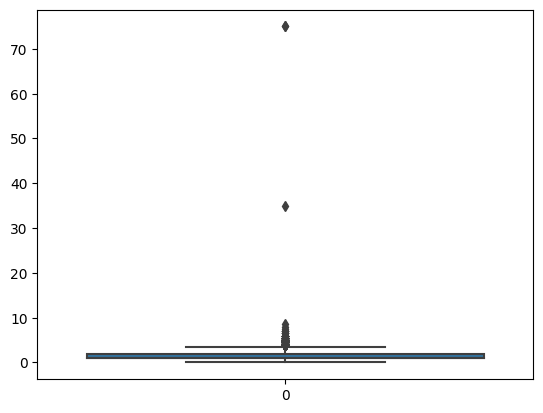

In [252]:
sns.boxplot(data['baths'])
data['baths'].nlargest(5)

In [17]:
median = data['baths'].median()
std = data['baths'].std()
mean =  data['baths'].mean()

data['z_score'] = (data['baths'] - mean) / std

print(f'Outliers found: ' + str(len(data[data['z_score'] > 3])))

Outliers found: 2084


In [28]:
print(data['baths'].max())
print(data['baths'].median())
print(data['baths'].mean())
print(data['baths'].mode())
print(data['baths'].describe())

75.0
1.0
1.4825833772476884
0    1.0
Name: baths, dtype: float64
count    263771.000000
mean          1.482583
std           0.629427
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          75.000000
Name: baths, dtype: float64


3.0
1.0
1.4583767737924185
0    1.0
Name: baths, dtype: float64
count    263771.000000
mean          1.458377
std           0.548537
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: baths, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_15868\2093763862.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['baths'])


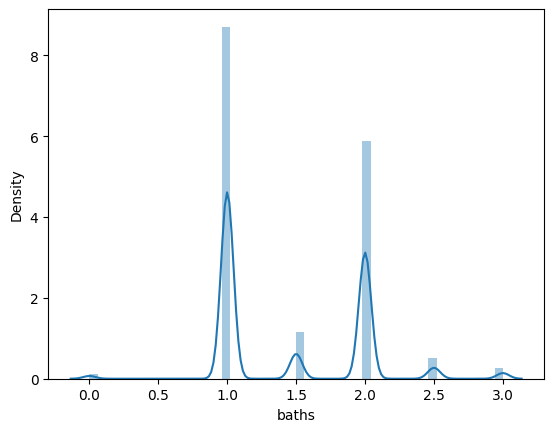

In [18]:
data['baths'] = np.where(data['z_score'] > 3, median, data['baths'])

print(data['baths'].max())
print(data['baths'].median())
print(data['baths'].mean())
print(data['baths'].mode())
print(data['baths'].describe())

sns.distplot(data['baths'])

data.drop('z_score', axis=1, inplace=True)

### 5) Seeking for Correlations

We are studying the correlation between the main features. 

C:\Users\user\AppData\Local\Temp\ipykernel_6528\1237155619.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



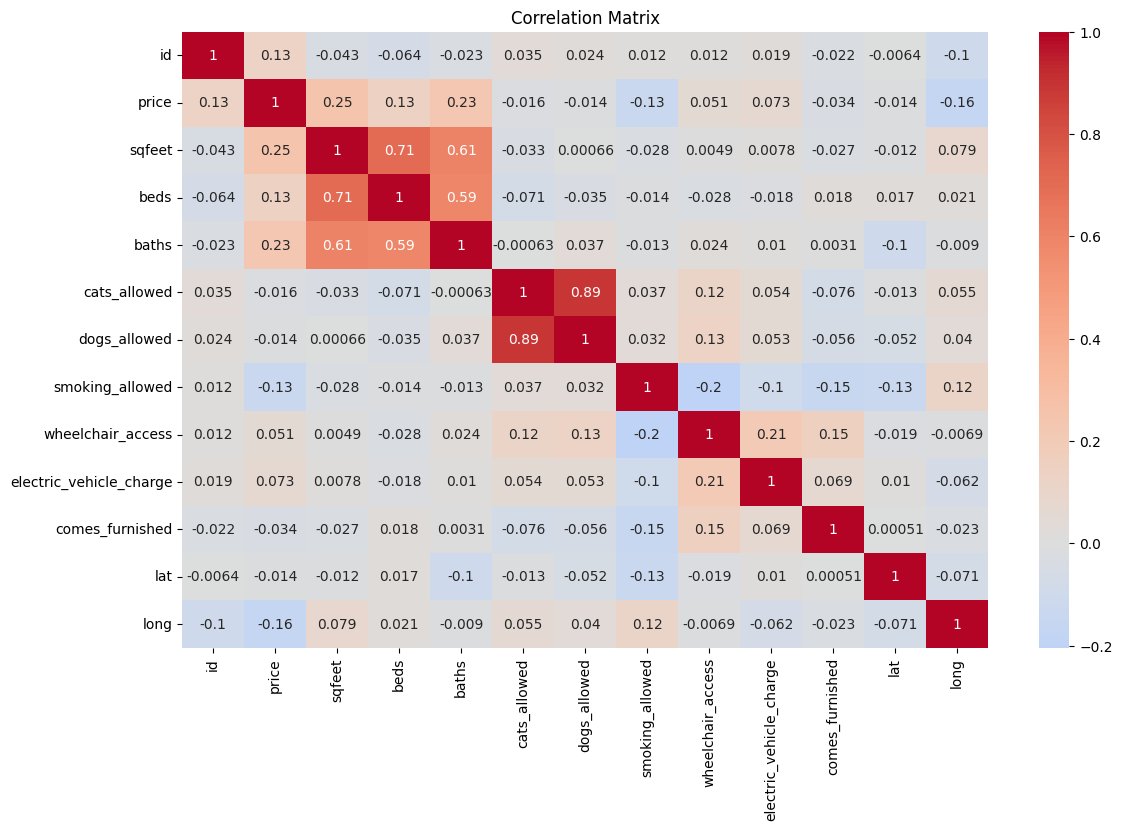

In [47]:
#df_correlation = data[['price', 'sqfeet','beds', 'baths','cats_allowed', 'dogs_allowed', 'smoking_allowed', 
#                  'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']]

correlation_matrix = data.corr()

plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

Focusing a little bit more into the correlation just with price, we can notice interesting outputs.

In [48]:
# Crear una serie que contenga las correlaciones entre 'price' y las demás columnas
correlations_with_price = correlation_matrix['price']

# Filtrar las columnas que tienen una correlación mayor a 0.05
#selected_columns = correlations_with_price[correlations_with_price > 0.05].index.tolist()

# Crear un nuevo DataFrame con las columnas seleccionadas
#df_filtered = data[selected_columns]

correlations_with_price

id                         0.125690
price                      1.000000
sqfeet                     0.254863
beds                       0.134632
baths                      0.230335
cats_allowed              -0.016179
dogs_allowed              -0.013989
smoking_allowed           -0.129613
wheelchair_access          0.050513
electric_vehicle_charge    0.072705
comes_furnished           -0.033692
lat                       -0.014088
long                      -0.163577
Name: price, dtype: float64

1) Longitude has a stronger relationship with price than latitude.
2) The only features that has more than 10% of correlation with the price are: 

a) sqfeet

b) beds

c) baths

d) smoking_allowed

e) longitude

f) id ¿Why id? It might as well been that the creator introduced the data in that order, which is just a coincidence.

We are dropping the features that are not really important for the prediction.

In [19]:
df_main = data.copy()

In [20]:
df_main.drop(['id', 'url', 'region_url', 'image_url', 'description', 'lat', 'long'], axis = 1, inplace = True)
#We eliminate lat and long taking as an assumtion that this info is going to be found in the region and state.

In [73]:
df_main.dtypes

region                      object
price                      float64
type                        object
sqfeet                     float64
beds                       float64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
state                       object
dtype: object

In [21]:
print(f'Total of unique values of regions: ' + str(len(df_main['region'].unique())))
print(f'Total of unique values of type: ' + str(len(df_main['type'].unique())))
print(f'Total of unique values of laundry_options: ' + str(len(df_main['laundry_options'].unique())))
print(f'Total of unique values of parking_options: ' + str(len(df_main['parking_options'].unique())))
print(f'Total of unique values of state: ' + str(len(df_main['state'].unique())))

Total of unique values of regions: 298
Total of unique values of type: 12
Total of unique values of laundry_options: 5
Total of unique values of parking_options: 7
Total of unique values of state: 38


### 6) Featuring Engineering

We need to convert the categorical data into numerical one. We have to be carefull, it is different when we have categorical values that have a clear order, from those who haven't.

Let's start with the region (which doesn't have an order)

### 6.1) Region and State

In [22]:
#dictionary=dict(df_main['region'].value_counts())
#df_main['region']=df_main['region'].map(dictionary)

#dictionary=dict(df_main['state'].value_counts())
#df_main['state']=df_main['state'].map(dictionary)


mean_per_region = df_main.groupby('region')['price'].mean().astype(int).to_dict()
df_main['region'] = df_main['region'].map(mean_per_region)


mean_per_state = df_main.groupby('state')['price'].mean().astype(int).to_dict()
df_main['state'] = df_main['state'].map(mean_per_state)

#### 6.2) Laundry options

In this case we can actually order the options.

In [23]:
laundry_order = df_main.groupby('laundry_options')['price'].mean().sort_values()
laundry_order

laundry_options
no laundry on site     985.604760
laundry on site       1013.147628
laundry in bldg       1021.130421
w/d hookups           1047.572374
w/d in unit           1268.198747
Name: price, dtype: float64

In [24]:
dict_laundry_options = {}
dict_laundry_options['no laundry on site'] = 1
dict_laundry_options['laundry on site'] = 2
dict_laundry_options['laundry in bldg'] = 3
dict_laundry_options['w/d hookups'] = 4
dict_laundry_options['w/d in unit'] = 5

df_main['laundry_options'] = df_main['laundry_options'].map(dict_laundry_options)

#### 6.3) Parking Options

In [25]:
parking_order = df_main.groupby('parking_options')['price'].mean().sort_values()
parking_order

parking_options
off-street parking    1048.021086
street parking        1123.232571
no parking            1134.730252
carport               1198.187847
detached garage       1200.653976
valet parking         1259.831579
attached garage       1304.739534
Name: price, dtype: float64

In [26]:
dict_parking_options = {}
dict_parking_options['no parking'] = 1
dict_parking_options['street parking'] = 2
dict_parking_options['off-street parking'] = 3
dict_parking_options['carport'] = 4
dict_parking_options['detached garage'] = 5
dict_parking_options['valet parking'] = 6
dict_parking_options['attached garage'] = 7

df_main['parking_options'] = df_main['parking_options'].map(dict_parking_options)

#### 6.4) Type

In [27]:
type_order = df_main.groupby('type')['price'].mean().sort_values()
type_order

type
assisted living     175.000000
land                787.500000
manufactured        913.557923
cottage/cabin       940.764706
apartment          1121.010963
duplex             1167.339930
house              1175.481410
townhouse          1205.903643
loft               1226.947059
in-law             1263.930556
condo              1360.880810
flat               1400.323782
Name: price, dtype: float64

In [28]:
dict_type_options = {}
dict_type_options['assisted living'] = 1
dict_type_options['land'] = 2
dict_type_options['manufactured'] = 3
dict_type_options['cottage/cabin'] = 4
dict_type_options['apartment'] = 5
dict_type_options['duplex'] = 6
dict_type_options['house'] = 7
dict_type_options['townhouse'] = 8
dict_type_options['loft'] = 9
dict_type_options['in-law'] = 10
dict_type_options['condo'] = 11
dict_type_options['flat'] = 12

df_main['type'] = df_main['type'].map(dict_type_options)

In [101]:
df_main.dtypes

region                       int64
price                      float64
type                         int64
sqfeet                     float64
beds                       float64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options              int64
parking_options              int64
state                        int64
dtype: object

In [102]:
df_main.head()

region   price  type  sqfeet  beds  baths  cats_allowed  dogs_allowed  \
0     956  1195.0     5  1908.0   3.0    2.0             1             1   
1     956  1120.0     5  1319.0   3.0    2.0             1             1   
2     956   825.0     5  1133.0   1.0    1.5             1             1   
3     956   800.0     5   927.0   1.0    1.0             1             1   
4     956   785.0     5  1047.0   2.0    1.0             1             1   

   smoking_allowed  wheelchair_access  electric_vehicle_charge  \
0                1                  0                        0   
1                1                  0                        0   
2                1                  0                        0   
3                1                  0                        0   
4                1                  0                        0   

   comes_furnished  laundry_options  parking_options  state  
0                0                2                2    864  
1                0                2                3    864  
2                0                2                2    864  
3                0                2                2    864  
4                0                2                2    864

### 7) Model Prediction

#### 7.1) Selecting the model

First we split the data

In [29]:
y = df_main['price']
x = df_main.drop('price', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state = 21)

We are going to try different models to find the one that adjust the better.

In [30]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('RandomForest', RandomForestRegressor(random_state = 21)))
models.append(('Decision Tree', DecisionTreeRegressor( random_state = 21)))
models.append(('KNN', KNeighborsRegressor(n_neighbors = 5)))

In [37]:
for name,model in models:
    print(name)

    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)

    r2 = r2_score(y_pred, y_test)
    n = len(y_test)
    p = x_test.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mse)

    print(f'r2 score: ' + str(r2) )
    print(f'adjusted_r2: ' + str(adjusted_r2) )
    print(f'mae: ' + str(mae) )
    print(f'rmse: ' + str(rmse) )
    print("\n")

LinearRegression
r2 score: 0.06021109600523533
adjusted_r2: 0.05996162606484989
mae: 215.1164417727606
rmse: 308.5668922547454


RandomForest
r2 score: 0.7455306559649968
adjusted_r2: 0.7454631062718513
mae: 98.46838672448433
rmse: 201.22385763397108


Decision Tree
r2 score: 0.6458492679770813
adjusted_r2: 0.6457552575438557
mae: 113.10079466894368
rmse: 263.35846110773343


KNN
r2 score: 0.6507207695900095
adjusted_r2: 0.6506280523123125
mae: 120.49331437778409
rmse: 236.7291207188959




After looking into all the models, the one that look the better is the RandomForest. So now the last thing to do is to identify the best parameters for this model.

#### 7.2) Finding best parameters

In [31]:
new_x_train = x_train[0:1000]
new_y_train = y_train[0:1000]

C:\Users\user\AppData\Local\Temp\ipykernel_15868\2444555948.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  new_y_train = y_train[0:1000]


A normal option to use is GridSearchCV(). However, I tried and it took more than 6 hours so I reset the program, and then I tried an optimized option, the BayesSearchCV() .

In [108]:
forest_reg_class = RandomForestRegressor()

#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 4)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#Using a starting point
#bootstrap =  [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

grid_search = GridSearchCV(estimator = forest_reg_class, param_grid = random_grid, cv=3, verbose=2, n_jobs = -1)

In [111]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [32]:
param_space = {
    'n_estimators': (100, 600),
    'max_features': ['auto', 'sqrt'],
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
}

opt = BayesSearchCV(
    RandomForestRegressor(),
    param_space,
    n_iter= 50 ,  
    cv = 3,        
    n_jobs = -1,  
    verbose = 2, 
    random_state = 42,
)

opt.fit(new_x_train, new_y_train)

print("Best parameters found:")
print(opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:
OrderedDict([('max_depth', 7), ('max_features', 'auto'), ('min_samples_split', 2), ('n_estimators', 118)])


In [33]:
best_model = opt.best_estimator_
best_model.fit(new_x_train, new_y_train)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=7, max_features='auto', n_estimators=118)

In [35]:
y_pred = best_model.predict(x_test)

r2 = r2_score(y_pred, y_test)
n = len(y_test)
p = x_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)

print(f'r2 score: ' + str(r2) )
print(f'adjusted_r2: ' + str(adjusted_r2) )
print(f'mae: ' + str(mae) )
print(f'rmse: ' + str(rmse) )

r2 score: 0.15296361960277138
adjusted_r2: 0.15273877111347367
mae: 213.09698339920496
rmse: 307.25736466946535


As we can see, the r2 is worse than the model without optimizing. This is because we are using only a small sample of 1000 out of 265189. I do this because this project is only to show the process of creating the model, however, I don't want to let my computer run for days with this. 